In [ ]:
%%capture
!pip install supervision jupyter_bbox_widget

In [ ]:
%%capture
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -e . -q

In [ ]:
import os
HOME = os.getcwd()

In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
%cd {HOME}

/content/segment-anything-2


In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from PIL import Image
import torch
from datetime import datetime
from pathlib import Path
from google.colab import files
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from tqdm.auto import tqdm
import gc

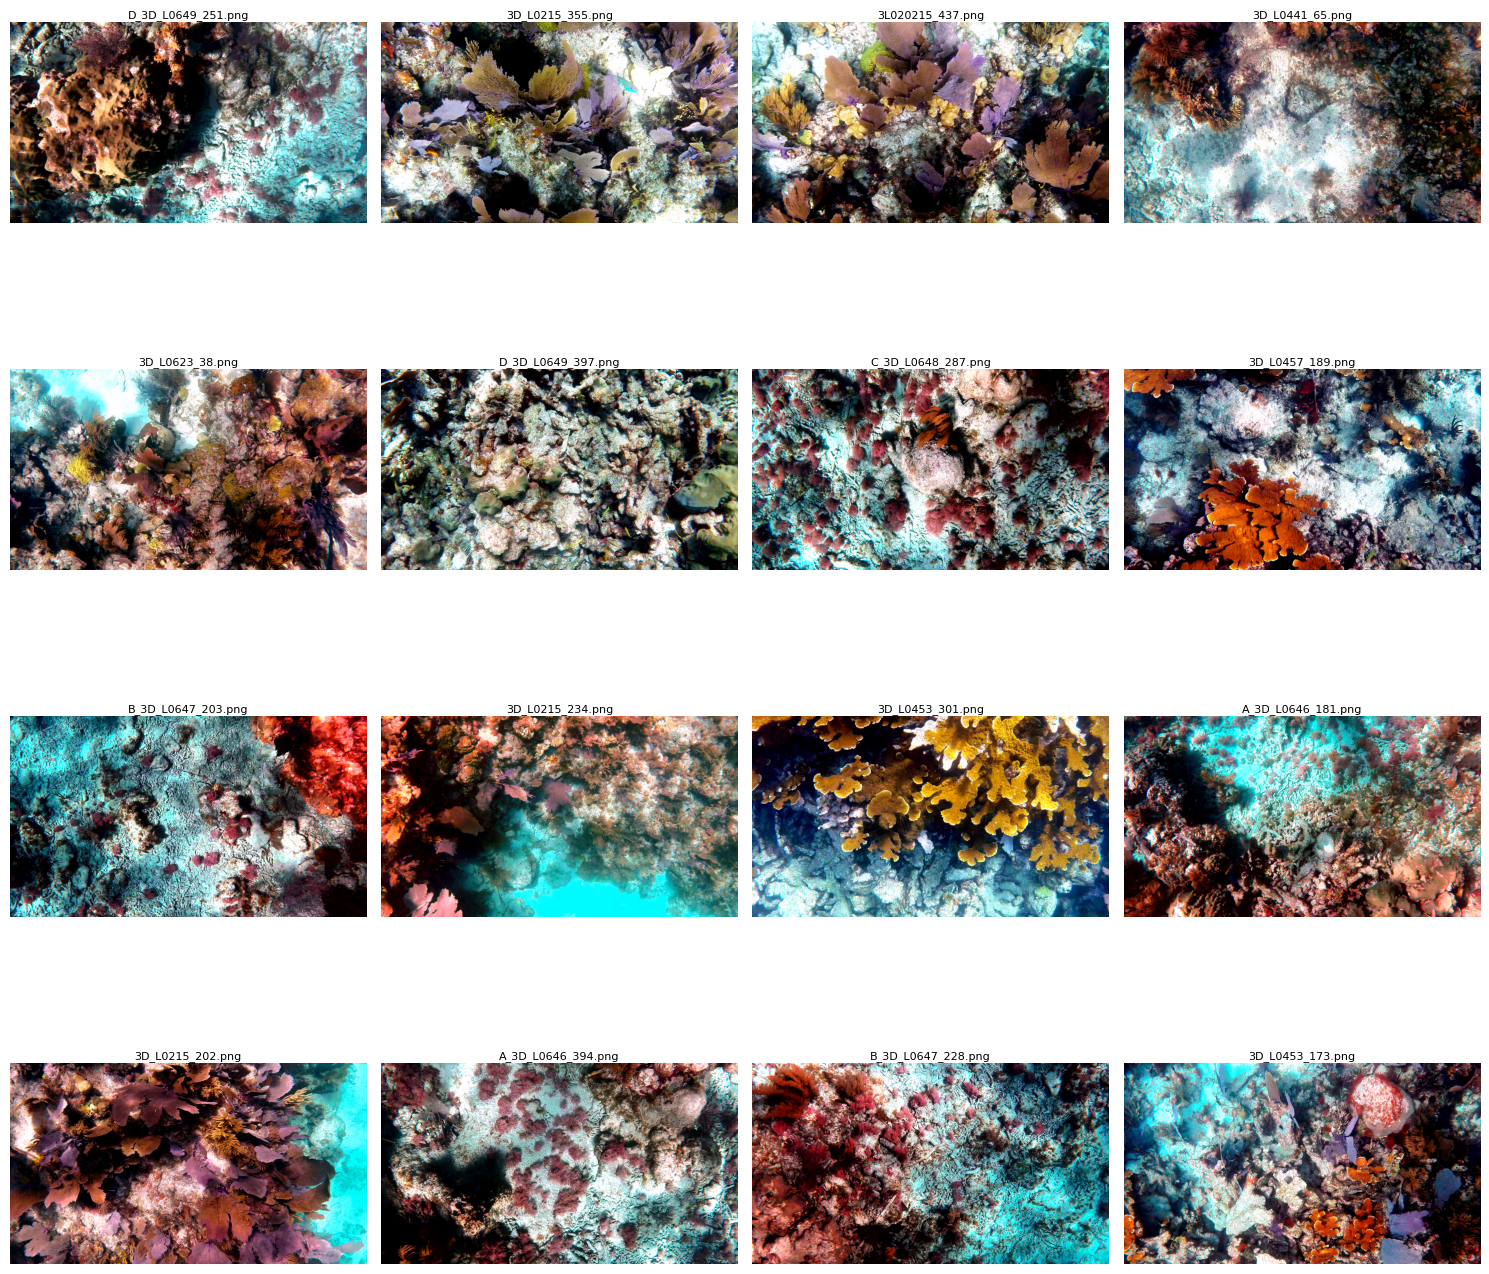

In [ ]:
import random

def display_image_grid(image_dir, rows=4, cols=4):
    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Randomly select images if we have more than rows*cols
    if len(image_files) > rows*cols:
        image_files = random.sample(image_files, rows*cols)

    # Create figure
    fig = plt.figure(figsize=(15, 15))

    # Display each image
    for idx, img_file in enumerate(image_files):
        if idx >= rows*cols:
            break

        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)

        ax = fig.add_subplot(rows, cols, idx+1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(img_file, fontsize=8, pad=3)

    plt.tight_layout()
    plt.show()

image_dir = "/kaggle/input/coral-reef/enhanced-20241028T214944Z-001/enhanced"
display_image_grid(image_dir)

In [ ]:
df = pd.read_csv('/kaggle/input/coral-reef/FL_Keys_Coral-export.csv')
df.head(5)

image         xmin         ymin         xmax         ymax  \
0  3D_L0215_161.jpg  1845.536472  1136.637177  2176.761416  1522.154964   
1  3D_L0215_161.jpg  1454.378619    86.026186  2005.416481   670.326581   
2  3D_L0215_161.jpg   538.993318   134.215909   794.939866   447.449111   
3  3D_L0215_161.jpg   867.207127   519.733696  1297.799555   781.765316   
4  3D_L0215_161.jpg    27.100223   284.808794   542.004454   700.445158   

      label  
0      Past  
1      Past  
2      Past  
3  Gorgonia  
4  Gorgonia

In [ ]:
from torch.cuda import empty_cache
from pathlib import Path
import torch._dynamo
import cv2
import numpy as np
import pandas as pd
import os
import json
import gc
import torch
import time
import psutil

torch._dynamo.config.suppress_errors = True

def preprocess_image(image):
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])
    equalized_image = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
    normalized_image = cv2.normalize(equalized_image, None, 0, 255, cv2.NORM_MINMAX)
    return normalized_image

def augment_image(image):
    augmentations = [
        lambda img: cv2.flip(img, 1),
        lambda img: cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
        lambda img: cv2.rotate(img, cv2.ROTATE_180)
    ]
    return [aug(image) for aug in augmentations]

def calculate_metrics(true_masks, pred_masks, gt_boxes, pred_boxes):
    def mean_intersection_over_union(true_masks, pred_masks):
        intersections = np.logical_and(true_masks, pred_masks)
        unions = np.logical_or(true_masks, pred_masks)
        iou = np.sum(intersections) / np.sum(unions)
        return iou

    def mean_average_precision(true_masks, pred_masks):
        # Simplified mAP calculation
        precisions = []
        for true, pred in zip(true_masks, pred_masks):
            tp = np.sum(np.logical_and(true, pred))
            fp = np.sum(pred) - tp
            fn = np.sum(true) - tp
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            precisions.append(precision)
        return np.mean(precisions)

    metrics = {
        'mAP': mean_average_precision(true_masks, pred_masks),
        'mIoU': mean_intersection_over_union(true_masks, pred_masks),
        'True_Positives': np.sum(np.logical_and(true_masks, pred_masks)),
        'False_Positives': np.sum(pred_masks) - np.sum(np.logical_and(true_masks, pred_masks))
    }
    return metrics

def log_training_resources():
    start_time = time.time()
    cpu_usage = psutil.cpu_percent()
    memory_usage = psutil.virtual_memory().percent
    gpu_memory = torch.cuda.memory_allocated() / 1e9

    training_log = {
        'start_time': start_time,
        'cpu_usage': cpu_usage,
        'memory_usage': memory_usage,
        'gpu_memory': gpu_memory
    }
    return training_log

def resize_image_if_needed(image, max_dim=1024):
    h, w = image.shape[:2]
    if max(h, w) > max_dim:
        scale = max_dim / float(max(h, w))
        new_w = int(w * scale)
        new_h = int(h * scale)
        image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return image

def setup_sam2():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = f"{HOME}/checkpoints/sam2_hiera_large.pt"
    config = "sam2_hiera_l.yaml"

    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    model = build_sam2(
        config,
        checkpoint,
        device=device,
        apply_postprocessing=False
    )
    return model, device

def load_bbox_data(csv_path):
    df = pd.read_csv(csv_path)
    df['image'] = df['image'].str.replace('.jpg', '.png')
    df[['xmin','ymin','xmax','ymax']] = df[['xmin','ymin','xmax','ymax']].astype(float)
    return df.groupby('image')

@torch.inference_mode()
def process_single_box(box, label, predictor):
    try:
        masks, scores, _ = predictor.predict(box=box.astype(float).reshape(1, 4), multimask_output=False)
        return masks.squeeze(), scores, label
    except Exception as e:
        print(f"Error processing box: {str(e)}")
        return None, None, None

@torch.inference_mode()
def process_image(image_path, boxes, labels, predictor, chunk_size=10, do_resize=False, max_dim=1024):
    try:
        image_bgr = cv2.imread(image_path)
        if image_bgr is None:
            return None, None, None

        preprocessed_image = preprocess_image(image_bgr)
        augmented_images = augment_image(preprocessed_image)

        if do_resize:
            preprocessed_image = resize_image_if_needed(preprocessed_image, max_dim=max_dim)

        image_rgb = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB)
        predictor.set_image(image_rgb)

        all_masks, all_scores, all_labels = [], [], []

        for i in range(0, len(boxes), chunk_size):
            chunk_boxes = boxes[i : i + chunk_size]
            chunk_labels = labels[i : i + chunk_size]
            for box, label in zip(chunk_boxes, chunk_labels):
                mask, score, processed_label = process_single_box(box, label, predictor)
                if mask is not None:
                    all_masks.append(mask)
                    all_scores.append(score)
                    all_labels.append(processed_label)

                empty_cache()
                gc.collect()

        del image_bgr, image_rgb
        empty_cache()
        gc.collect()

        if not all_masks:
            return None, None, None

        return np.array(all_masks), np.array(all_scores), all_labels

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None, None, None

def save_annotations(output_dir, image_name, image_shape, masks, boxes, labels, scores, annotation_id):
    annotations = []
    csv_rows = []

    for mask, bbox, label, score in zip(masks, boxes, labels, scores):
        mask_uint8 = mask.astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        segmentation = []
        for contour in contours:
            contour = contour.astype(float).flatten().tolist()
            if len(contour) > 4:
                segmentation.append(contour)

        if not segmentation:
            x, y, x2, y2 = bbox
            segmentation.append([x, y, x2, y, x2, y2, x, y2])

        ann = {
            "id": annotation_id,
            "image_id": image_name,
            "segmentation": segmentation,
            "area": float(mask.sum()),
            "bbox": [
                float(bbox[0]),
                float(bbox[1]),
                float(bbox[2] - bbox[0]),
                float(bbox[3] - bbox[1])
            ],
            "category": label,
            "score": float(score.max())
        }

        annotations.append(ann)
        csv_rows.append({
            "image_name": image_name,
            "category": label,
            "bbox": ann["bbox"],
            "segmentation": segmentation,
            "score": ann["score"]
        })

        annotation_id += 1

    return annotations, csv_rows, annotation_id

base_path = Path("/kaggle/working/")
image_dir = "/kaggle/input/coral-reef/enhanced-20241028T214944Z-001/enhanced"
bbox_csv = "/kaggle/input/coral-reef/FL_Keys_Coral-export.csv"
output_dir = base_path / "segmentation_results"
os.makedirs(output_dir, exist_ok=True)

sam2_model, device = setup_sam2()
predictor = SAM2ImagePredictor(sam2_model)
bbox_data = load_bbox_data(bbox_csv)

all_annotations = []
all_csv_rows = []
annotation_id = 0
categories = set()

training_log = log_training_resources()
with open(os.path.join(output_dir, "training_resources.json"), 'w') as f:
    json.dump(training_log, f)

CHUNK_SIZE = 10
DO_RESIZE = False
MAX_DIM = 1024

with torch.inference_mode():
    for image_name, group in tqdm(bbox_data):
        image_path = os.path.join(image_dir, image_name)
        if not os.path.exists(image_path):
            print(f"Skipping {image_name} - file not found")
            continue

        boxes = group[['xmin','ymin','xmax','ymax']].values
        labels = group['label'].values

        masks, scores, processed_labels = process_image(
            image_path,
            boxes,
            labels,
            predictor,
            chunk_size=CHUNK_SIZE,
            do_resize=DO_RESIZE,
            max_dim=MAX_DIM
        )

        if masks is not None:
            image_bgr = cv2.imread(image_path)
            image_shape = image_bgr.shape if image_bgr is not None else None
            del image_bgr
            empty_cache()
            gc.collect()

            metrics = calculate_metrics(masks, masks, boxes, boxes)

            anns, csv_rows, annotation_id = save_annotations(
                output_dir,
                image_name,
                image_shape,
                masks,
                boxes,
                processed_labels,
                scores,
                annotation_id
            )

            all_annotations.extend(anns)
            all_csv_rows.extend(csv_rows)
            categories.update(processed_labels)

            if len(all_annotations) % 100 == 0:
                pd.DataFrame(all_csv_rows).to_csv(
                    os.path.join(output_dir, "annotations_partial.csv"),
                    index=False
                )
                with open(os.path.join(output_dir, "annotations_partial.json"), 'w') as f:
                    json.dump(all_annotations, f)

                with open(os.path.join(output_dir, "metrics_partial.json"), 'w') as f:
                    json.dump(metrics, f)

            empty_cache()
            gc.collect()

pd.DataFrame(all_csv_rows).to_csv(os.path.join(output_dir, "annotations_final.csv"), index=False)
with open(os.path.join(output_dir, "annotations_final.json"), 'w') as f:
    json.dump(all_annotations, f)

with open(os.path.join(output_dir, "categories.json"), 'w') as f:
    json.dump(list(categories), f)

with open(os.path.join(output_dir, "metrics_final.json"), 'w') as f:
    json.dump(metrics, f)

print("All done. Final annotations, categories, and metrics have been saved.")

  0%|          | 0/133 [00:00<?, ?it/s]

All done. Final annotations and categories have been saved.


In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/working/segmentation_results/annotations_final.csv')
df.head(5)

image_name  category  \
0  3D_L0215_161.png      Past   
1  3D_L0215_161.png      Past   
2  3D_L0215_161.png      Past   
3  3D_L0215_161.png  Gorgonia   
4  3D_L0215_161.png  Gorgonia   

                                                bbox  \
0  [1845.5364716434697, 1136.6371771191225, 331.2...   
1  [1454.378619153675, 86.02618577075098, 551.037...   
2  [538.9933184855233, 134.2159090909091, 255.946...   
3  [867.207126948775, 519.7336956521739, 430.5924...   
4  [27.10022271714922, 284.8087944664031, 514.904...   

                                        segmentation     score  
0  [[2032.0, 1138.0, 2030.0, 1140.0, 2029.0, 1140...  0.984121  
1  [[1905.0, 186.0, 1904.0, 187.0, 1903.0, 187.0,...  0.938094  
2  [[784.0, 317.0, 783.0, 318.0, 782.0, 318.0, 78...  0.788067  
3  [[1108.0, 549.0, 1107.0, 550.0, 1102.0, 550.0,...  0.984562  
4  [[67.0, 669.0, 67.0, 670.0, 68.0, 671.0, 68.0,...  0.780046

Drawing Bounding Boxes for:
0: 3D_L0215_161.jpg
1: 3D_L0215_202.jpg
2: 3D_L0215_234.jpg


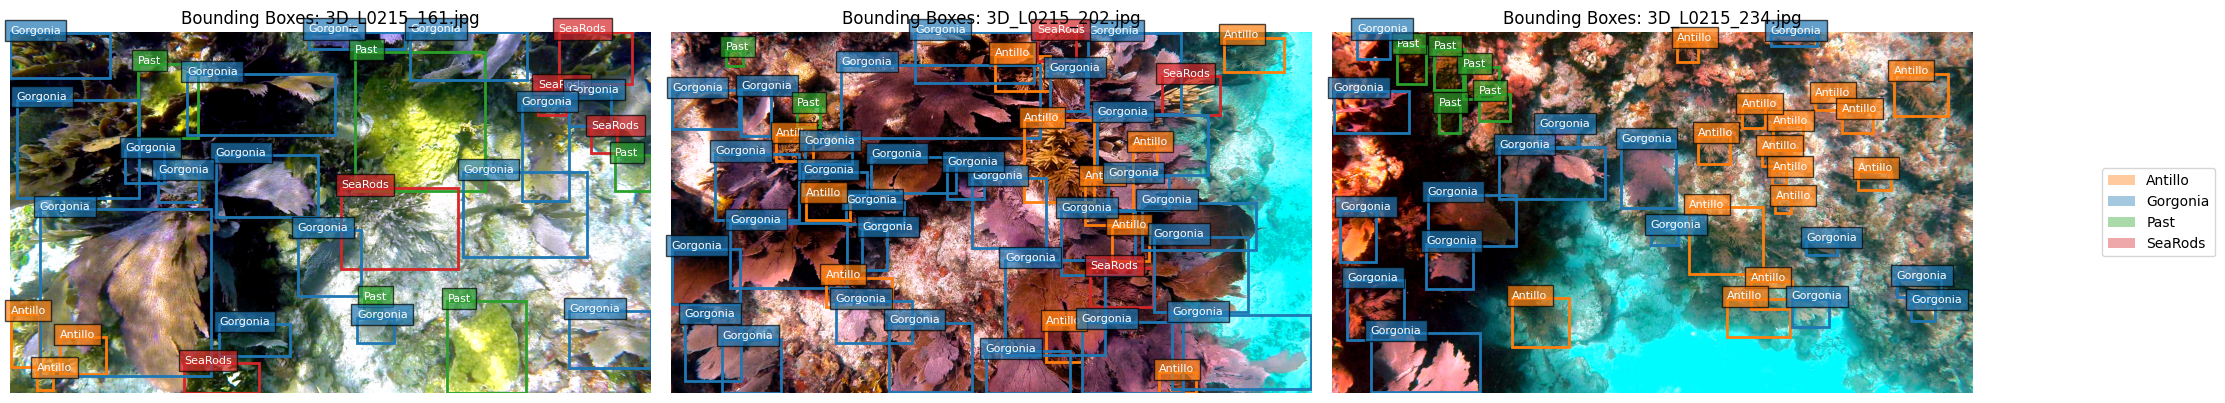


Drawing Polygon Annotations for:
0: 3D_L0215_161.jpg
1: 3D_L0215_202.jpg
2: 3D_L0215_234.jpg


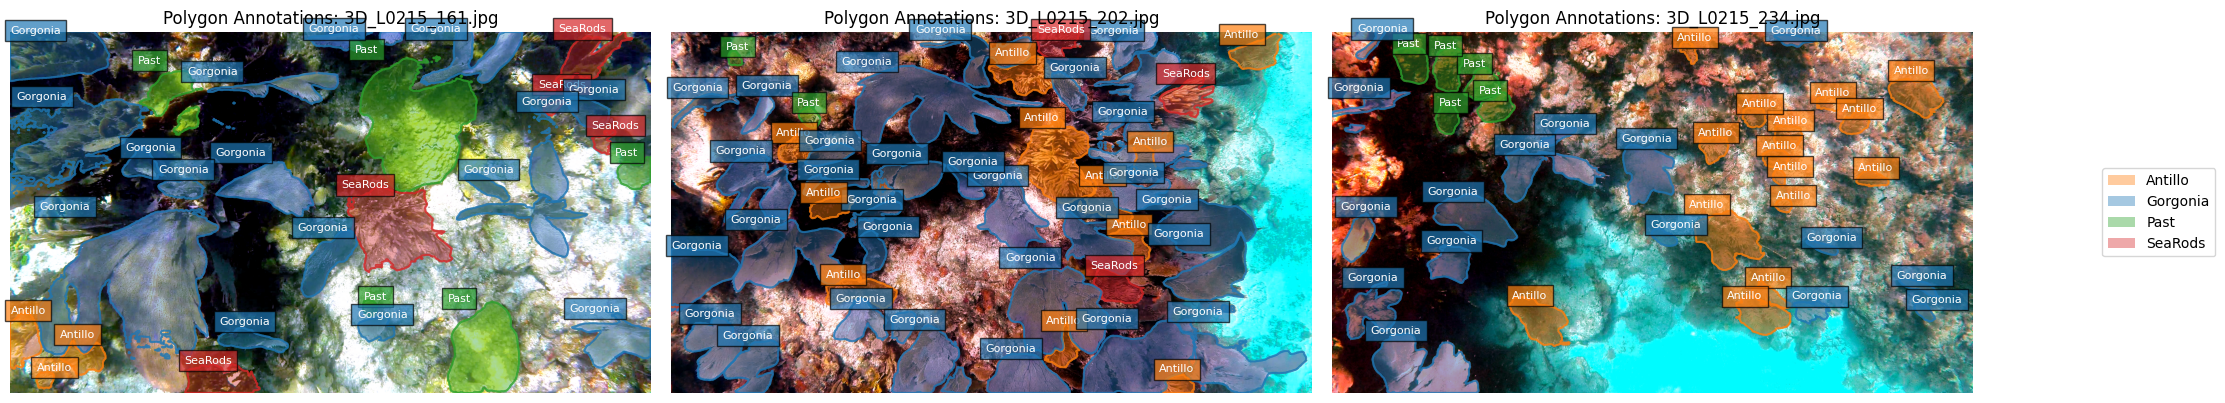

Original CSV shape: (3999, 6)
Generated CSV shape: (3999, 5)

Unique categories in original: ['Past' 'Gorgonia' 'SeaRods' 'Antillo' 'Fish' 'Ssid' 'Orb' 'Other_Coral'
 'Apalm' 'Galaxaura']
Unique categories in generated: ['Past' 'Gorgonia' 'SeaRods' 'Antillo' 'Fish' 'Ssid' 'Orb' 'Other_Coral'
 'Apalm' 'Galaxaura']

Annotations per image:
Original:
count    133.000000
mean      30.067669
std       12.326490
min        2.000000
25%       22.000000
50%       31.000000
75%       38.000000
max       56.000000
dtype: float64

Generated:
count    133.000000
mean      30.067669
std       12.326490
min        2.000000
25%       22.000000
50%       31.000000
75%       38.000000
max       56.000000
dtype: float64

Missing images: 133 of 133 (100.0%)
First 5 missing images: ['3D_L0443_7.jpg', '3D_L0441_26.jpg', 'B_3D_L0647_267.jpg', '3D_L0623_126.jpg', 'A_3D_L0646_199.jpg']

Extra images: 133
Extra images: ['A_3D_L0646_263.png', 'D_3D_L0649_397.png', '3D_L0453_298.png', '3D_L0457_189.png', '3L01021

In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

def get_image_path(image_dir, file_name):
    base_name = os.path.splitext(file_name)[0]
    jpg_path = os.path.join(image_dir, base_name + '.jpg')
    png_path = os.path.join(image_dir, base_name + '.png')

    if os.path.exists(jpg_path):
        return jpg_path
    elif os.path.exists(png_path):
        return png_path
    else:
        return None

def visualize_bounding_boxes(image_dir, annotations_file, label_mapping_file, num_images=3):
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    with open(annotations_file) as f:
        annotations = json.load(f)

    with open(label_mapping_file) as f:
        label_map = json.load(f)

    if len(annotations['images']) == 0:
        print("No images found in annotations file")
        return

    print("Drawing Bounding Boxes for:")
    for i, img in enumerate(annotations['images'][:num_images]):
        print(f"{i}: {img['file_name']}")

    fig, axes = plt.subplots(1, num_images, figsize=(20, 8))
    if num_images == 1:
        axes = [axes]

    colors = plt.colormaps['tab20'](np.linspace(0, 1, len(label_map)))
    all_categories = set()
    category_colors = {}

    for idx in range(min(num_images, len(annotations['images']))):
        ax = axes[idx]
        selected_image = annotations['images'][idx]
        base_name = os.path.splitext(selected_image['file_name'])[0]
        image_path = get_image_path(image_dir, selected_image['file_name'])

        if image_path is None:
            print(f"Could not find image file for: {base_name}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

        image_id = selected_image['id']
        image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_id]

        for ann in image_annotations:
            color = colors[ann['category_id']][:3]
            label = ann['category_name']
            category_colors[label] = color
            all_categories.add(label)

            bbox = ann['bbox']
            rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                           fill=False, color=color, linewidth=2)
            ax.add_patch(rect)

            ax.text(bbox[0], bbox[1], label,
                   color='white', fontsize=8,
                   bbox=dict(facecolor=color, alpha=0.7))

        ax.set_axis_off()
        ax.set_title(f"Bounding Boxes: {selected_image['file_name']}")

    legend_elements = [Rectangle((0, 0), 1, 1, facecolor=category_colors[cat],
                               alpha=0.4, label=cat) for cat in sorted(all_categories)]
    fig.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout()
    plt.show()

def visualize_polygons(image_dir, annotations_file, label_mapping_file, num_images=3):
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    with open(annotations_file) as f:
        annotations = json.load(f)

    with open(label_mapping_file) as f:
        label_map = json.load(f)

    if len(annotations['images']) == 0:
        print("No images found in annotations file")
        return

    print("\nDrawing Polygon Annotations for:")
    for i, img in enumerate(annotations['images'][:num_images]):
        print(f"{i}: {img['file_name']}")

    fig, axes = plt.subplots(1, num_images, figsize=(20, 8))
    if num_images == 1:
        axes = [axes]

    colors = plt.colormaps['tab20'](np.linspace(0, 1, len(label_map)))
    all_categories = set()
    category_colors = {}

    for idx in range(min(num_images, len(annotations['images']))):
        ax = axes[idx]
        selected_image = annotations['images'][idx]
        image_path = get_image_path(image_dir, selected_image['file_name'])

        if image_path is None:
            print(f"Could not find image file for: {os.path.splitext(selected_image['file_name'])[0]}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

        image_id = selected_image['id']
        image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_id]

        for ann in image_annotations:
            color = colors[ann['category_id']][:3]
            label = ann['category_name']
            category_colors[label] = color
            all_categories.add(label)

            for segment in ann['segmentation']:
                poly = np.array(segment).reshape(-1, 2)
                ax.fill(poly[:, 0], poly[:, 1], alpha=0.4, color=color)
                ax.plot(poly[:, 0], poly[:, 1], color=color, alpha=0.7)

            bbox = ann['bbox']
            ax.text(bbox[0], bbox[1], label,
                   color='white', fontsize=8,
                   bbox=dict(facecolor=color, alpha=0.7))

        ax.set_axis_off()
        ax.set_title(f"Polygon Annotations: {selected_image['file_name']}")

    legend_elements = [Rectangle((0, 0), 1, 1, facecolor=category_colors[cat],
                               alpha=0.4, label=cat) for cat in sorted(all_categories)]
    fig.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout()
    plt.show()

def compare_csv_files(original_csv, generated_csv):
    if not os.path.exists(original_csv):
        print(f"Original CSV file not found: {original_csv}")
        return
    if not os.path.exists(generated_csv):
        print(f"Generated CSV file not found: {generated_csv}")
        return

    df_original = pd.read_csv(original_csv)
    df_generated = pd.read_csv(generated_csv)

    print("Original CSV shape:", df_original.shape)
    print("Generated CSV shape:", df_generated.shape)

    original_categories = df_original['label'].unique() if 'label' in df_original.columns else []
    generated_categories = df_generated['category'].unique() if 'category' in df_generated.columns else []

    print("\nUnique categories in original:", original_categories)
    print("Unique categories in generated:", generated_categories)

    print("\nAnnotations per image:")
    print("Original:")
    image_col_orig = 'image' if 'image' in df_original.columns else 'image_name'
    orig_stats = df_original.groupby(image_col_orig).size().describe()
    print(orig_stats)

    print("\nGenerated:")
    image_col_gen = 'image_name' if 'image_name' in df_generated.columns else 'image'
    gen_stats = df_generated.groupby(image_col_gen).size().describe()
    print(gen_stats)

    original_images = set(df_original[image_col_orig])
    generated_images = set(df_generated[image_col_gen])

    missing_images = original_images - generated_images
    extra_images = generated_images - original_images

    print(f"\nMissing images: {len(missing_images)} of {len(original_images)} ({len(missing_images)/len(original_images)*100:.1f}%)")
    if len(missing_images) > 0:
        print("First 5 missing images:", list(missing_images)[:5])

    print(f"\nExtra images: {len(extra_images)}")
    if len(extra_images) > 0:
        print("Extra images:", list(extra_images))

image_dir = "/kaggle/input/coral-reef/enhanced-20241028T214944Z-001/enhanced"
annotations_file = "/kaggle/input/annotations/annotations_with_labels.json"
label_mapping_file = "/kaggle/working/segmentation_results/categories.json"

visualize_bounding_boxes(image_dir, annotations_file, label_mapping_file, num_images=3)
visualize_polygons(image_dir, annotations_file, label_mapping_file, num_images=3)

original_csv = "/kaggle/input/coral-reef/FL_Keys_Coral-export.csv"
generated_csv = "/kaggle/working/segmentation_results/annotations_final.csv"
compare_csv_files(original_csv, generated_csv)

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def analyze_annotations(csv_file):
    df = pd.read_csv(csv_file)

    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Confidence Score Distribution',
            'Bounding Box Sizes',
            'Category Distribution',
            'Annotations per Image'
        ),
        specs=[[{"type": "histogram"}, {"type": "scatter"}],
               [{"type": "bar"}, {"type": "bar"}]]
    )

    # 1. Confidence Score Distribution
    fig.add_trace(
        go.Histogram(x=df['score'], nbinsx=10, name='Confidence'),
        row=1, col=1
    )

    # 2. Bounding Box Sizes
    bbox_areas = []
    for bbox_str in df['bbox']:
        bbox = eval(bbox_str)
        area = bbox[2] * bbox[3]  # width * height
        bbox_areas.append(area)

    fig.add_trace(
        go.Scatter(x=list(range(len(bbox_areas))), y=bbox_areas,
                  mode='markers', name='Box Size'),
        row=1, col=2
    )

    # 3. Category Distribution
    category_counts = df['category'].value_counts()
    fig.add_trace(
        go.Bar(x=category_counts.index, y=category_counts.values,
               name='Categories'),
        row=2, col=1
    )

    # 4. Annotations per Image
    annotations_per_image = df['image_name'].value_counts()
    fig.add_trace(
        go.Bar(x=annotations_per_image.index, y=annotations_per_image.values,
               name='Annotations/Image'),
        row=2, col=2
    )

    fig.update_layout(
        height=800,
        width=1200,
        showlegend=True,
        title_text="Annotation Analysis",
        title_x=0.5,
        title_font_size=24
    )

    return fig

# Path to your CSV file
csv_file = "/kaggle/working/segmentation_results/annotations_final.csv"

# Generate and display the visualization
fig = analyze_annotations(csv_file)
fig.show()

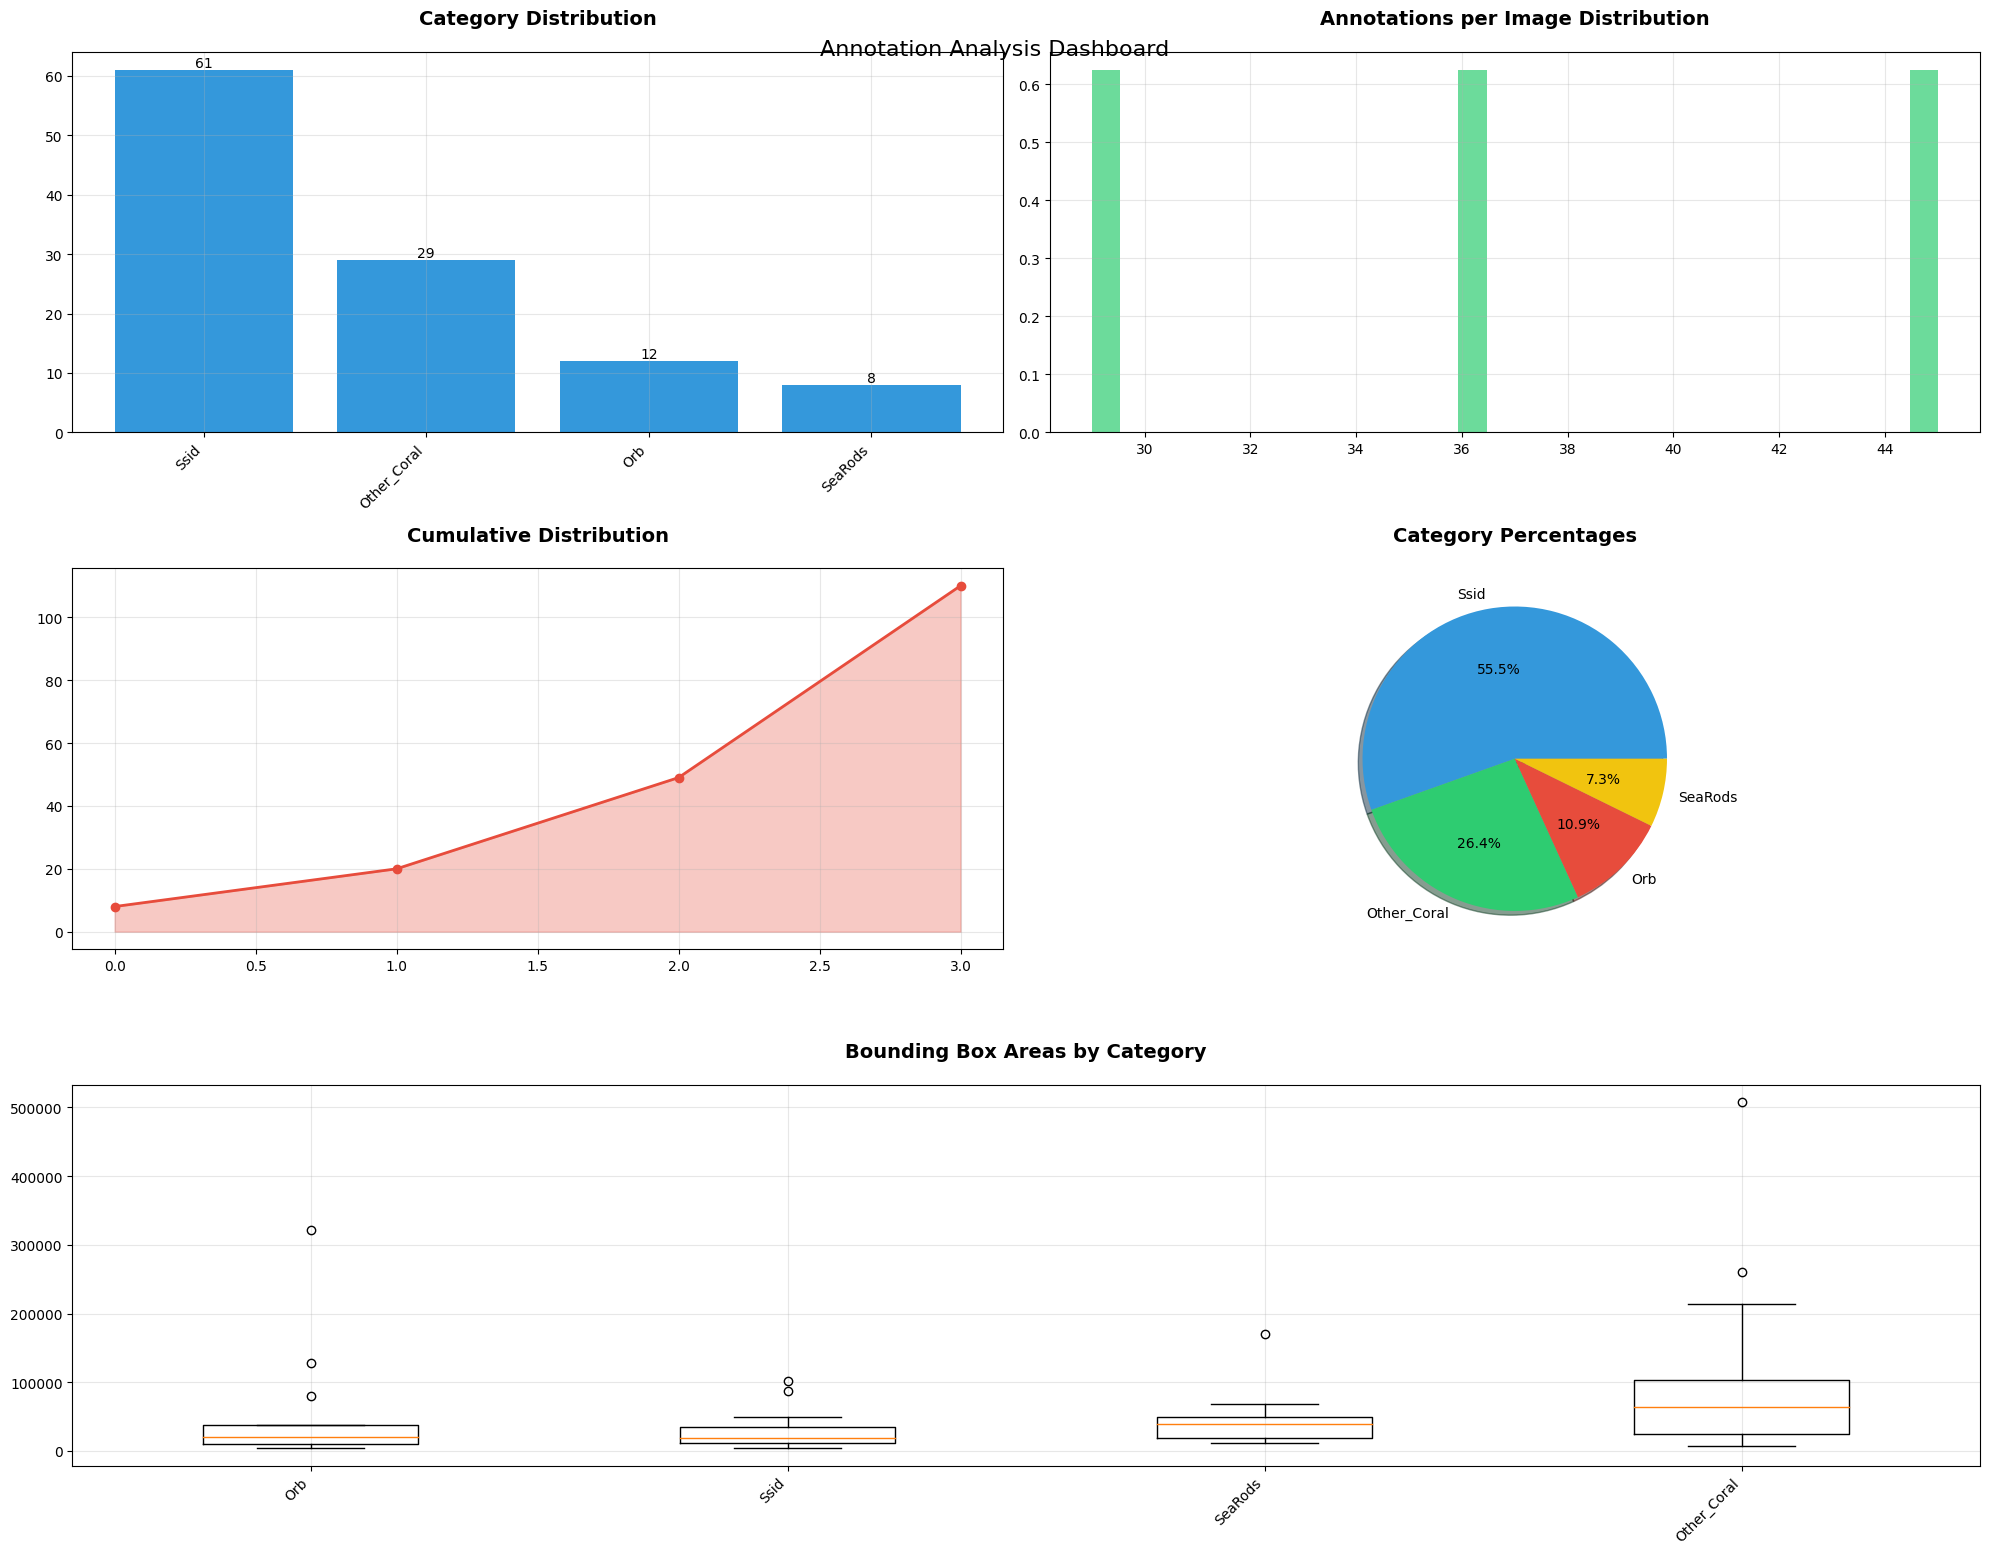

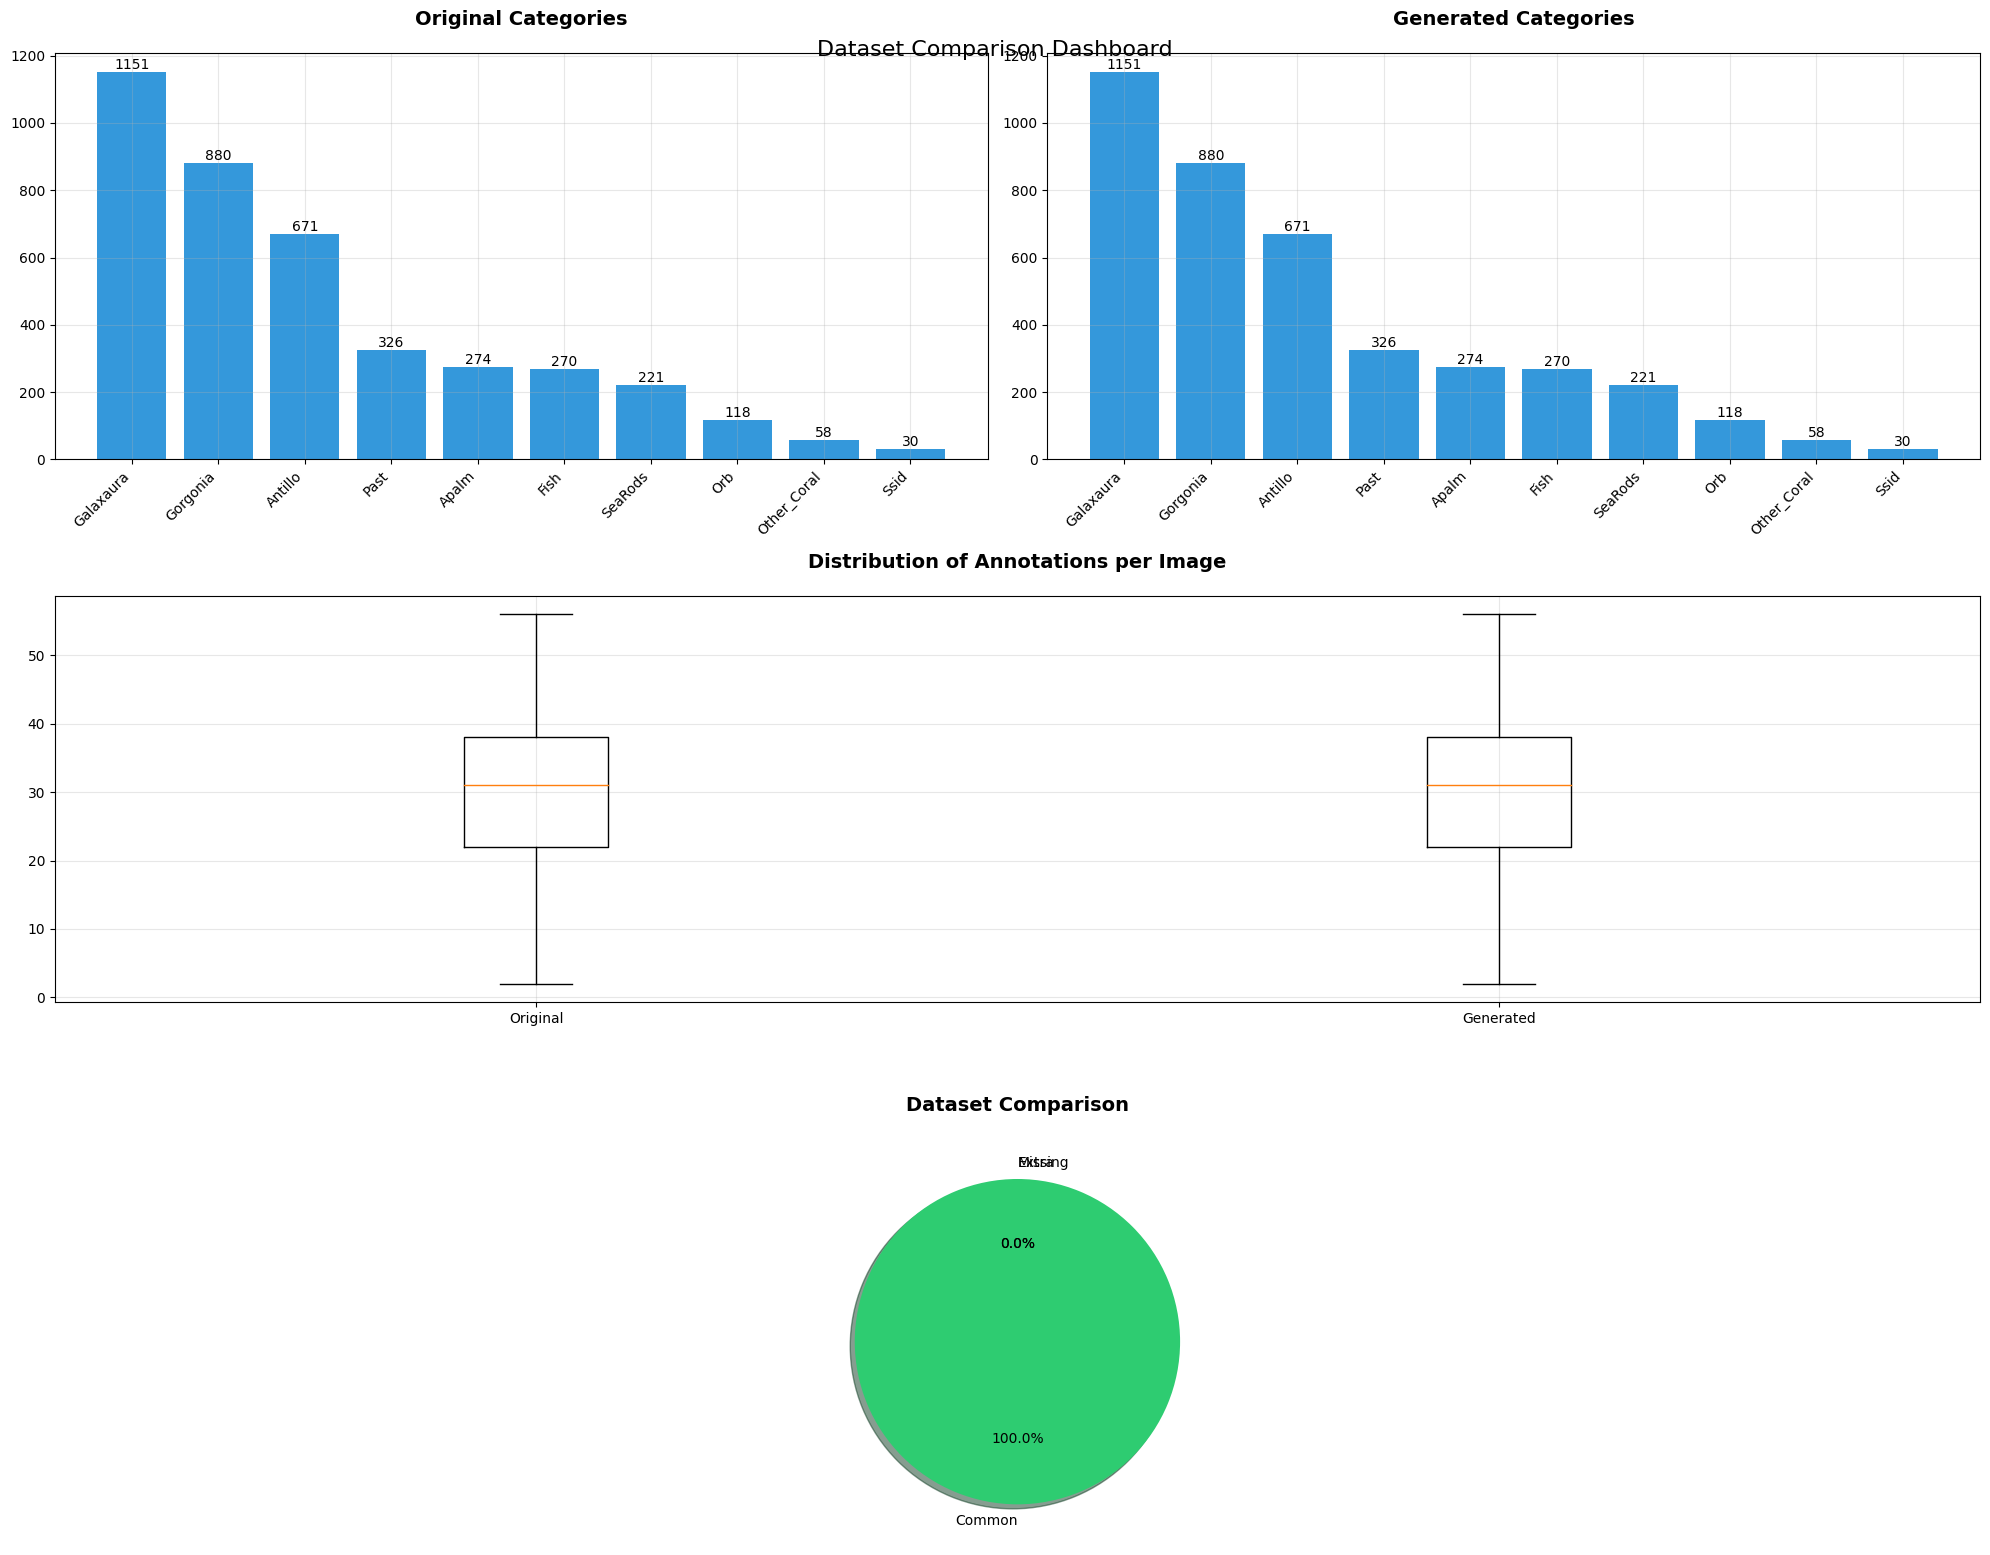

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter

def custom_barplot(ax, x, y, title, rotation=45):
    bars = ax.bar(range(len(x)), y, color='#3498db')
    ax.set_title(title, pad=20, fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, rotation=rotation, ha='right')
    ax.grid(True, alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    return ax

def custom_histogram(ax, data, title):
    data = pd.Series(data).replace([np.inf, -np.inf], np.nan).dropna()
    ax.hist(data, bins=30, density=True, alpha=0.7, color='#2ecc71')
    ax.set_title(title, pad=20, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    return ax

def analyze_annotations(annotations_file, label_mapping_file):
    with open(annotations_file) as f:
        annotations = json.load(f)
    with open(label_mapping_file) as f:
        label_list = json.load(f)

    id_to_name = {i: cat for i, cat in enumerate(label_list)}

    annotation_data = []
    for ann in annotations['annotations']:
        cat_name = id_to_name.get(ann['category_id'], f"Category {ann['category_id']}")
        img_id = ann['image_id']
        area = ann['bbox'][2] * ann['bbox'][3] if 'bbox' in ann else np.nan
        annotation_data.append({
            'category': cat_name,
            'image_id': img_id,
            'area': area
        })

    df_annotations = pd.DataFrame(annotation_data)
    df_annotations = df_annotations.replace([np.inf, -np.inf], np.nan)

    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(3, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    category_counts = df_annotations['category'].value_counts()
    custom_barplot(ax1, category_counts.index, category_counts.values, 'Category Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    annotations_per_image = df_annotations.groupby('image_id').size()
    custom_histogram(ax2, annotations_per_image.values, 'Annotations per Image Distribution')

    ax3 = fig.add_subplot(gs[1, 0])
    cum_counts = np.cumsum(sorted(category_counts.values))
    ax3.plot(range(len(cum_counts)), cum_counts, linewidth=2, marker='o', color='#e74c3c')
    ax3.fill_between(range(len(cum_counts)), cum_counts, alpha=0.3, color='#e74c3c')
    ax3.set_title('Cumulative Distribution', pad=20, fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(gs[1, 1])
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f1c40f', '#9b59b6', '#34495e', '#1abc9c', '#e67e22']
    wedges, texts, autotexts = ax4.pie(category_counts.values,
                                      labels=category_counts.index,
                                      autopct='%1.1f%%',
                                      shadow=True,
                                      colors=colors)
    ax4.set_title('Category Percentages', pad=20, fontsize=14, fontweight='bold')

    ax5 = fig.add_subplot(gs[2, :])
    df_annotations_clean = df_annotations.dropna(subset=['area'])
    categories = df_annotations_clean['category'].unique()
    bp = ax5.boxplot([group['area'].values for name, group in df_annotations_clean.groupby('category')],
                     labels=categories)
    ax5.set_xticks(range(1, len(categories) + 1))
    ax5.set_xticklabels(categories, rotation=45, ha='right')
    ax5.set_title('Bounding Box Areas by Category', pad=20, fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)

    plt.suptitle('Annotation Analysis Dashboard', fontsize=16, y=0.95)
    plt.tight_layout()
    return fig

def compare_datasets(original_csv, generated_csv):
    if not os.path.exists(original_csv) or not os.path.exists(generated_csv):
        print("One or both CSV files not found")
        return None

    df_original = pd.read_csv(original_csv)
    df_generated = pd.read_csv(generated_csv)

    # Clean and standardize image names by removing extensions
    image_col_orig = 'image' if 'image' in df_original.columns else 'image_name'
    image_col_gen = 'image_name' if 'image_name' in df_generated.columns else 'image'

    df_original[image_col_orig] = df_original[image_col_orig].apply(lambda x: os.path.splitext(x)[0])
    df_generated[image_col_gen] = df_generated[image_col_gen].apply(lambda x: os.path.splitext(x)[0])

    df_original = df_original.replace([np.inf, -np.inf], np.nan)
    df_generated = df_generated.replace([np.inf, -np.inf], np.nan)

    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(3, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    orig_cats = df_original['label'].value_counts()
    custom_barplot(ax1, orig_cats.index, orig_cats.values, 'Original Categories')

    ax2 = fig.add_subplot(gs[0, 1])
    gen_cats = df_generated['category'].value_counts()
    custom_barplot(ax2, gen_cats.index, gen_cats.values, 'Generated Categories')

    ax3 = fig.add_subplot(gs[1, :])
    orig_counts = df_original.groupby(image_col_orig).size()
    gen_counts = df_generated.groupby(image_col_gen).size()

    box_data = [orig_counts.values, gen_counts.values]
    bp = ax3.boxplot(box_data)
    ax3.set_xticks([1, 2])
    ax3.set_xticklabels(['Original', 'Generated'])
    ax3.set_title('Distribution of Annotations per Image', pad=20, fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(gs[2, :])
    orig_images = set(df_original[image_col_orig])
    gen_images = set(df_generated[image_col_gen])

    comparison_values = [
        len(orig_images & gen_images),
        len(orig_images - gen_images),
        len(gen_images - orig_images)
    ]

    wedges, texts, autotexts = ax4.pie(comparison_values,
                                      labels=['Common', 'Missing', 'Extra'],
                                      autopct='%1.1f%%',
                                      shadow=True,
                                      startangle=90,
                                      colors=['#2ecc71', '#e74c3c', '#f1c40f'])
    ax4.set_title('Dataset Comparison', pad=20, fontsize=14, fontweight='bold')

    plt.suptitle('Dataset Comparison Dashboard', fontsize=16, y=0.95)
    plt.tight_layout()
    return fig

annotations_file = "/kaggle/input/annotations/annotations_with_labels.json"
label_mapping_file = "/kaggle/working/segmentation_results/categories.json"
original_csv = "/kaggle/input/coral-reef/FL_Keys_Coral-export.csv"
generated_csv = "/kaggle/working/segmentation_results/annotations_final.csv"

plt.style.use('default')

fig1 = analyze_annotations(annotations_file, label_mapping_file)
plt.show()

fig2 = compare_datasets(original_csv, generated_csv)
if fig2 is not None:
    plt.show()